In [1]:
import matplotlib
import matplotlib.pyplot as plt
import imageio

In [2]:
import numpy as np

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

In [4]:
from StarKiller.initialization import starkiller_initialize
from StarKiller.interfaces import BurnType, EosType
from StarKiller.integration import Integrator
from StarKiller.network import Network
from StarKiller.eos import Eos

In [5]:
starkiller_initialize("probin_aprox13")
network = Network()
integrator = Integrator()


Initialized StarKiller with ...
- EOS:     helmholtz
- Network: aprox13


In [6]:
# Set use_cuda=True to use an available GPU
use_cuda=True

In [7]:
# Input sampling domain & scaling
dens = 1.0e8
temp = 4.0e8
xhe = 1.0

end_time = 1.0

time_scale = 1.0e-6
density_scale = dens
temperature_scale = temp * 10

# do an eos call to set the internal energy scale
eos = Eos()
eos_state = EosType()

# pick a composition for normalization of Ye = 0.5 w/ abar = 12, zbar = 6
eos_state.state.abar = 12.0
eos_state.state.zbar = 6.0
eos_state.state.y_e = eos_state.state.zbar / eos_state.state.abar
eos_state.state.mu_e = 1.0 / eos_state.state.y_e

# use_raw_inputs uses only abar, zbar, y_e, mu_e for the EOS call
# instead of setting those from the mass fractions
eos.evaluate(eos_state.eos_input_rt, eos_state, use_raw_inputs=True)

energy_scale = eos_state.state.e

print("density_scale = ", density_scale)
print("temperature_scale = ", temperature_scale)
print("energy_scale = ", energy_scale)

density_scale =  100000000.0
temperature_scale =  4000000000.0
energy_scale =  8948090280514663.0


In [8]:
# size of training set
NumSamples = 256

In [9]:
# get the solution given t
def sol(t):
    y = torch.zeros(NumSamples, network.nspec+2)
    
    for i, time in enumerate(t):
        # get the time
        time = time.item()
        
        # construct a burn type
        state_in = BurnType()

        # set density & temperature
        state_in.state.rho = dens
        state_in.state.t = temp

        # mass fractions
        state_in.state.xn = np.zeros(network.nspec)
        state_in.state.xn[:] = (1.0-xhe)/(network.nspec-1)
        state_in.state.xn[network.species_map["he4"]] = xhe

        # integrate to get the output state
        state_out = integrator.integrate(state_in, time * time_scale)
        
        # set the solution values
        for n in range(network.nspec):
            y[i][n] = state_out.state.xn[n]
        y[i][network.net_itemp] = state_out.state.t / temperature_scale
        y[i][network.net_ienuc] = state_out.state.e / energy_scale
    
    return y

In [10]:
# get the solution rhs given y
# scaled solution: ys = y / y_scale
# scaled time: ts = t / t_scale
# f = dys/dts = (dy/y_scale) / (dt/t_scale) = (dy/dt) * (t_scale / y_scale)
def rhs(y):
    dydt = torch.zeros(NumSamples, network.nspec+2)

    for i, yi in enumerate(y):
        # construct a burn type
        state = BurnType()

        # set density & temperature
        state.state.rho = dens
        state.state.t = max(yi[network.net_itemp] * temperature_scale, 0.0)

        # mass fractions
        for n in range(network.nspec):
            state.state.xn[n] = max(yi[n], 0.0)

        # evaluate the rhs
        network.rhs(state)
        
        # get rhs
        f = network.rhs_to_x(state.ydot)
        for n in range(network.nspec):
            dydt[i][n] = f[n] * time_scale

        dydt[i][network.net_itemp] = f[network.net_itemp] * time_scale / temperature_scale
        dydt[i][network.net_ienuc] = f[network.net_ienuc] * time_scale / energy_scale
            
    return dydt

In [11]:
x = torch.unsqueeze(torch.linspace(0, 1.0, NumSamples, requires_grad=True), dim=1)
x_test = torch.unsqueeze(torch.rand(NumSamples, requires_grad=True), dim=1) * end_time

# get the truth solution as a function of x
y = sol(x)

# get the truth solution at the test points x_test
y_test = sol(x_test)

# get the analytic right-hand-side as a function of y(x)
# f(x) = dy(x)/dx
dydx = rhs(y)

if use_cuda:
    x = x.cuda()
    y = y.cuda()
    x_test = x_test.cuda()
    y_test = y_test.cuda()
    dydx = dydx.cuda()

In [12]:
# we will want to propagate gradients through y, dydx, and x
# so make them PyTorch Variables
x = Variable(x, requires_grad=True)
y = Variable(y, requires_grad=True)
dydx = Variable(dydx, requires_grad=True)

# we will need to evaluate gradients w.r.t. x multiple
# times so tell PyTorch to save the gradient variable in x.
x.retain_grad()

In [13]:
# get numpy versions of x,y,f on the cpu for plotting
xnp = x.cpu().data.numpy()
ynp = y.cpu().data.numpy()
fnp = dydx.cpu().data.numpy()

Text(0, 0.5, 'T')

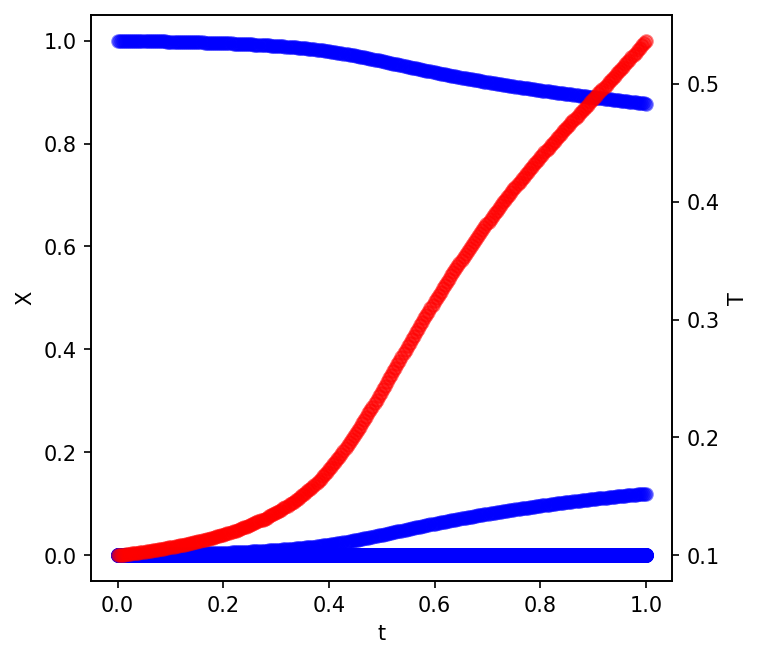

In [14]:
# plot the truth values
fig, axis = plt.subplots(figsize=(5,5), dpi=150)
axis_t = axis.twinx()

for n in range(network.nspec):
    axis.scatter(xnp, ynp[:,n],
                 color='blue', alpha=0.5)
    
axis_t.scatter(xnp, ynp[:,network.net_itemp],
               color='red', alpha=0.5)

axis.set_ylabel("X")
axis.set_xlabel("t")
axis_t.set_ylabel("T")

Text(0, 0.5, 'dT/dt')

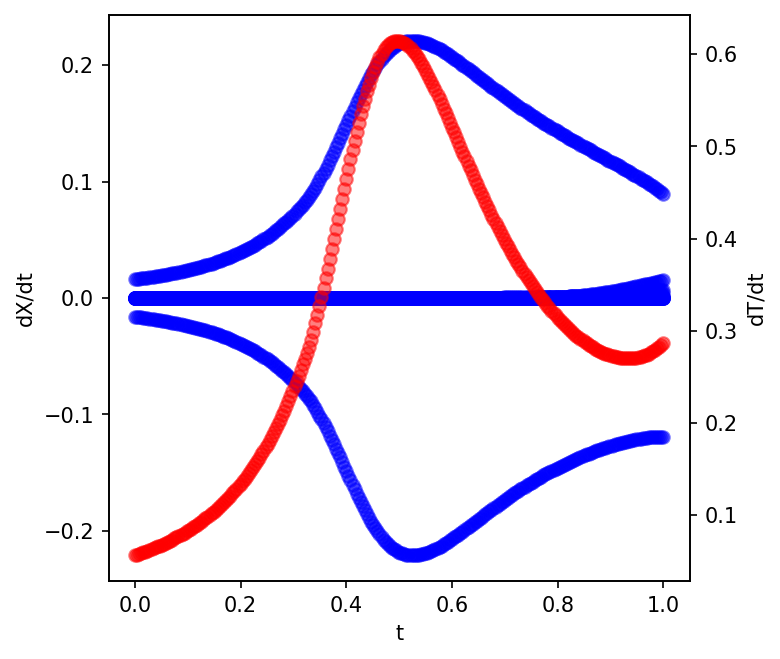

In [15]:
# plot the truth rhs
fig, axis = plt.subplots(figsize=(5,5), dpi=150)
axis_t = axis.twinx()

for n in range(network.nspec):
    axis.scatter(xnp, fnp[:,n],
                 color='blue', alpha=0.5)
    
axis_t.scatter(xnp, fnp[:,network.net_itemp],
               color='red', alpha=0.5)

axis.set_ylabel("dX/dt")
axis.set_xlabel("t")
axis_t.set_ylabel("dT/dt")

In [16]:
class HiddenNet(nn.Module):
    def __init__(self, n_independent, n_dependent,
                 n_hidden, hidden_depth, activation):
        super(HiddenNet, self).__init__()
        
        self.activation = activation
        self.input_layer = nn.Linear(n_independent, n_hidden)
        self.hidden_layers = nn.ModuleList()
        for i in range(hidden_depth):
            self.hidden_layers.append(nn.Linear(n_hidden, n_hidden))
        self.output_layer = nn.Linear(n_hidden, n_dependent)
        
    def forward(self, x):
        x = self.activation(self.input_layer(x))
        for h in self.hidden_layers:
            x = self.activation(h(x))
        x = self.output_layer(x)
        return x

In [17]:
# activations, e.g. F.celu, torch.tanh

net = HiddenNet(n_independent=1, n_dependent=network.nspec+2,
                n_hidden=network.nspec+2, hidden_depth=10, activation=torch.tanh)

In [18]:
if use_cuda:
    net.cuda()

In [19]:
print(net)

HiddenNet(
  (input_layer): Linear(in_features=1, out_features=15, bias=True)
  (hidden_layers): ModuleList(
    (0): Linear(in_features=15, out_features=15, bias=True)
    (1): Linear(in_features=15, out_features=15, bias=True)
    (2): Linear(in_features=15, out_features=15, bias=True)
    (3): Linear(in_features=15, out_features=15, bias=True)
    (4): Linear(in_features=15, out_features=15, bias=True)
    (5): Linear(in_features=15, out_features=15, bias=True)
    (6): Linear(in_features=15, out_features=15, bias=True)
    (7): Linear(in_features=15, out_features=15, bias=True)
    (8): Linear(in_features=15, out_features=15, bias=True)
    (9): Linear(in_features=15, out_features=15, bias=True)
  )
  (output_layer): Linear(in_features=15, out_features=15, bias=True)
)


In [20]:
optimizer_sgd = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
optimizer_adam = torch.optim.Adam(net.parameters(), lr=0.001)

In [21]:
loss_func = torch.nn.MSELoss()

In [22]:
training_images = []

# get a multipanel figure showing the prediction (p) and error (e)
%matplotlib agg

fig, (axis_p, axis_f, axis_e) = plt.subplots(nrows=3, ncols=1, figsize=(8,8), dpi=150)
axis_e1 = axis_e.twinx()
axis_p_t = axis_p.twinx()
axis_f_t = axis_f.twinx()

In [23]:
# arrays for accumulating the epoch index and losses for plotting
epochs = []
losses = []
losses0 = []
losses1 = []
tlosses = []

In [24]:
# this function is the training loop over epochs
# where 1 epoch trains over the whole training dataset
def train_error(NumEpochs):
    for t in range(NumEpochs):
        # calculate prediction given the current net state
        prediction = net(x)

        # calculate error between prediction and analytic truth y
        loss0 = torch.sqrt(loss_func(prediction, y))

        # first, zero out the existing gradients to avoid
        # accumulating gradients on top of existing gradients
        net.zero_grad()

        # calculate gradients d(prediction)/d(x) for each component
        def get_component_gradient(n):
            if x.grad is not None:
                x.grad.data.zero_()

            # now get the gradients dp_n/dt
            prediction[:,n].backward(torch.ones_like(prediction[:,n]), retain_graph=True)
            # clone the x gradient to save a copy of it as dp_n/dt
            dpndx = x.grad.clone()
            # clear the x gradient for the loss gradient below
            x.grad.data.zero_()
            
            # return dp_n/dt
            return dpndx
        
        dpdx = torch.ones_like(prediction)

        for i in range(network.nspec+2):
            dpdx[:,i] = torch.flatten(get_component_gradient(i))

        # define the error of the prediction derivative using the analytic derivative
        loss1 = torch.sqrt(loss_func(dpdx, dydx))

        # total error combines the error of the prediction (loss0) with 
        # the error of the prediction derivative (loss1)
        loss = loss0 + loss1

        # use the Adam optimizer
        optimizer = optimizer_adam

        # clear gradients for the next training iteration
        optimizer.zero_grad()

        # compute backpropagation gradients
        loss.backward()

        # apply gradients to update the weights
        optimizer.step()

        # generate plots
        if t % 100 == 0:
            # only calculate the following if we're doing I/O
            # get error with testing samples
            prediction_test = net(x_test)
            test_loss = torch.sqrt(loss_func(prediction_test, y_test)).cpu().data.numpy()
        
            # evaluate the analytic right-hand-side function at the prediction value
            prhs = rhs(prediction)
            
            # Prediction plots to show learning progress
            
            # clear previously drawn curves
            axis_p.clear()
            axis_p_t.clear()

            axis_p.set_ylabel('Solution', fontsize=22)

            pnp = prediction.cpu().data.numpy()
            
            for n in range(network.nspec):
                axis_p.plot(xnp, pnp[:,n],
                            color='green', lw=3, alpha=0.5)

                axis_p.scatter(xnp, ynp[:,n],
                               color='blue', alpha=0.5, s=20)
                
            axis_p_t.plot(xnp, pnp[:,network.net_itemp],
                          color='green', lw=3, alpha=0.5,
                          label='p(t)')

            axis_p_t.scatter(xnp, ynp[:,network.net_itemp],
                             color='red', alpha=0.5, s=20,
                             label='x(t)')

            # Plot analytic rhs vs prediction rhs
            pfnp = prhs.cpu().data.numpy()
            dpdxnp = dpdx.cpu().data.numpy()
            
            # clear previously drawn curves
            axis_f.clear()
            axis_f_t.clear()

            axis_f.set_ylabel('Gradient', fontsize=22)
            
            for n in range(network.nspec):
                axis_f.plot(xnp, pfnp[:,n],
                            color='green', lw=3, alpha=0.5)

                axis_f.plot(xnp, dpdxnp[:,n],
                            color='magenta', lw=3, ls=':', alpha=0.5)

                axis_f.scatter(xnp, fnp[:,n],
                               color='blue', alpha=0.5, s=20)
                
            axis_f_t.plot(xnp, pfnp[:,network.net_itemp],
                          color='green', lw=3, alpha=0.5,
                          label='f(p(t))')

            axis_f_t.plot(xnp, dpdxnp[:,network.net_itemp],
                          color='black', lw=3, ls=':', alpha=0.5,
                          label='dp(t)/dt')

            axis_f_t.scatter(xnp, fnp[:,network.net_itemp],
                             color='red', alpha=0.5, s=20,
                             label='f(x(t))')
            
            axis_f.tick_params(axis='both', which='major', labelsize=16)
            axis_f_t.tick_params(axis='both', which='major', labelsize=16)
            
            axis_f_t.legend(loc='upper right', borderpad=1, framealpha=0.5)
            
            # get min/max in x/y to set label positions relative to the axes
            xmin = 0
            xmax = 1
            ymin = 0
            ymax = 1

            height = np.abs(ymax - ymin)
            width = np.abs(xmax - xmin)

            axis_p.set_xlim(xmin, xmax)
            axis_p.set_ylim(ymin, ymax)

            axis_p.text(xmin, ymax + height*0.3,
                      'Step = %d' % t, fontdict={'size': 24, 'color': 'blue'})
            axis_p.text(xmin + width*0.5, ymax + height*0.3,
                      'Train Loss = %.2e' % loss.cpu().data.numpy(),
                      fontdict={'size': 24, 'color': 'blue'})
            axis_p.text(xmin + width*0.5, ymax + height*0.1,
                      'Test Loss = %.2e' % test_loss,
                      fontdict={'size': 24, 'color': 'orange'})

            axis_p.tick_params(axis='both', which='major', labelsize=16)
            axis_p_t.tick_params(axis='both', which='major', labelsize=16)

            # plot errors evolving with the number of epochs trained
            epochs.append(t)
            losses.append(loss.cpu().data.numpy())
            losses0.append(loss0.cpu().data.numpy())
            losses1.append(loss1.cpu().data.numpy())
            tlosses.append(test_loss)

            # clear previously drawn curves
            axis_e.clear()
            axis_e1.clear()

            axis_e.set_xlabel('Epoch', fontsize=22)
            axis_e.set_ylabel('E(p,x)', fontsize=22)

            axis_e.scatter([epochs[-1]], [losses0[-1]],
                           color="red", alpha=0.5)
            axis_e.plot(epochs, losses0,
                        'b-', lw=3, alpha=0.5,
                        label='E(p,x) [train]')

            axis_e.scatter([epochs[-1]], [test_loss],
                           color="red", alpha=0.5)
            axis_e.plot(epochs, tlosses,
                        'orange', lw=3, ls="--", alpha=0.5,
                        label='E(p,x) [test]')

            axis_e1.set_ylabel('E(dp/dt, f(x))', fontsize=22)
            
            axis_e1.scatter([epochs[-1]], [losses1[-1]],
                           color="red", alpha=0.5)
            axis_e1.plot(epochs, losses1,
                         'g-', lw=3, alpha=0.5,
                         label='E(dp/dt, f(x)) [train]')
            
            axis_e.get_yaxis().set_major_formatter(
                matplotlib.ticker.FuncFormatter(lambda x, p: "{:0.1f}".format(x)))
            
            axis_e1.get_yaxis().set_major_formatter(
                matplotlib.ticker.FuncFormatter(lambda x, p: "{:0.1f}".format(x)))

            axis_e.tick_params(axis='both', which='major', labelsize=16)
            axis_e1.tick_params(axis='both', which='major', labelsize=16)
            
            axis_e.legend(loc='upper right', borderpad=1, framealpha=0.5)
            axis_e1.legend(loc='upper center', borderpad=1, framealpha=0.5)
            
            # Draw on canvas and save image in sequence
            fig.canvas.draw()
            plt.tight_layout()
            image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
            image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))

            training_images.append(image)

            # Print epoch/error notifications
            if t % 100 == 0:
                print('epoch ', t, ' with error: ', losses[-1])
           
        # Stop early if our errors are plateauing
        if t > 1000:
            # do a quadratic polynomial fit and see if we will
            # need more than NumEpochs for the error e to vanish:
            # e / (d(e)/d(epoch)) > NumEpochs ?
            # if so, then break out of the training loop ...
            xfit = epochs[-4:]
            efit = losses[-4:]
            coef = np.polyfit(xfit, efit, 2)
            
            if coef[2]/coef[1] > NumEpochs:
                break

In [25]:
train_error(5000)

epoch  0  with error:  3.608124
epoch  100  with error:  3.1191063
epoch  200  with error:  3.109734
epoch  300  with error:  2.3540077
epoch  400  with error:  1.2031716
epoch  500  with error:  0.8507563
epoch  600  with error:  0.77144057
epoch  700  with error:  0.73809046
epoch  800  with error:  0.6989697
epoch  900  with error:  0.63321054
epoch  1000  with error:  0.5611879
epoch  1100  with error:  0.5136431
epoch  1200  with error:  0.48598453
epoch  1300  with error:  0.46616253
epoch  1400  with error:  0.4474525
epoch  1500  with error:  0.42639554
epoch  1600  with error:  0.39990175
epoch  1700  with error:  0.36395657
epoch  1800  with error:  0.31395337
epoch  1900  with error:  0.25004607
epoch  2000  with error:  0.19086216
epoch  2100  with error:  0.16088867
epoch  2200  with error:  0.15210548
epoch  2300  with error:  0.14917718
epoch  2400  with error:  0.14729519
epoch  2500  with error:  0.14559115
epoch  2600  with error:  0.14393684
epoch  2700  with error: 

In [26]:
imageio.mimsave('./starkiller.gif', training_images, fps=5)

In [27]:
print("final test sample error: ", tlosses[-1])

final test sample error:  0.0062405
